In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit,cuda
import time
import math
import multiprocessing
import cpuinfo

In [2]:
proc_name = cpuinfo.get_cpu_info()['brand_raw']
cores_count = multiprocessing.cpu_count()
print(f'Процессор: {proc_name}')
print(f'Количество ядер: {cores_count}')
print('GPU:')
!nvidia-smi

Процессор: Intel(R) Xeon(R) CPU @ 2.30GHz
Количество ядер: 2
GPU:
Fri Nov 17 11:00:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                      

In [3]:
size_num = 10
vector_size = np.linspace(1000,10000000,size_num)
iters = 10
tpb = 32
gpu_times = np.zeros(size_num)
cpu_times = np.zeros(size_num)
numpy_cpu_times = np.zeros(size_num)

In [4]:
def cpu_sum(vector):
    sum = 0
    for num in vector:
        sum+=num
    return sum

In [5]:
def numpy_cpu_sum(vector):
    return np.sum(vector)

In [6]:
@cuda.jit
def gpu_sum(vector,result):
  i,j = cuda.grid(2)
  idx = i+j
  sum = 0
  if idx < len(vector):

    sum += vector[idx]
    cuda.atomic.add(result, 0, sum)

In [7]:
for i,size in enumerate(vector_size):
    cpu_times_per_size = np.zeros(iters)
    gpu_times_per_size = np.zeros(iters)
    numpy_cpu_times_per_size = np.zeros(iters)

    vector = np.random.randn(int(size))
    result = np.zeros(1)

    gpu_vector = cuda.to_device(vector)
    for iter in range(iters):
        result_gpu = cuda.to_device(result)
        start  = time.time()
        gpu_sum[math.ceil(size/tpb),tpb](gpu_vector,result_gpu)
        gpu_times_per_size[iter] = time.time()-start
        gpu_res = result_gpu.copy_to_host()

        start = time.time()
        cpu_res = cpu_sum(vector)
        cpu_times_per_size[iter] = time.time() - start

        start = time.time()
        cpu_numpy_res = numpy_cpu_sum(vector)
        numpy_cpu_times_per_size[iter] = time.time() - start

    if np.allclose(gpu_res,cpu_numpy_res) and np.allclose(gpu_res, cpu_res):
        print(f'Результат вычисления суммы вектора размером {size} на gpu и cpu равны')
    else:
        print(f'Результат вычисления суммы вектора размером {size} на gpu и cpu не равны')
    cpu_times[i] = np.mean(cpu_times_per_size)
    numpy_cpu_times[i] = np.mean(numpy_cpu_times_per_size)
    gpu_times[i] = np.mean(gpu_times_per_size)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Результат вычисления суммы вектора размером 1000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 1112000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 2223000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 3334000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 4445000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 5556000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 6667000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 7778000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 8889000.0 на gpu и cpu равны
Результат вычисления суммы вектора размером 10000000.0 на gpu и cpu равны


In [8]:
data = pd.DataFrame(columns = ['avg cpu times','avg numpy cpu times','avg gpu times','boost'])
data['avg cpu times'] = cpu_times
data['avg numpy cpu times'] = numpy_cpu_times
data['avg gpu times'] = gpu_times
data['boost'] = numpy_cpu_times/gpu_times
data.to_csv('data.csv',sep='\t')

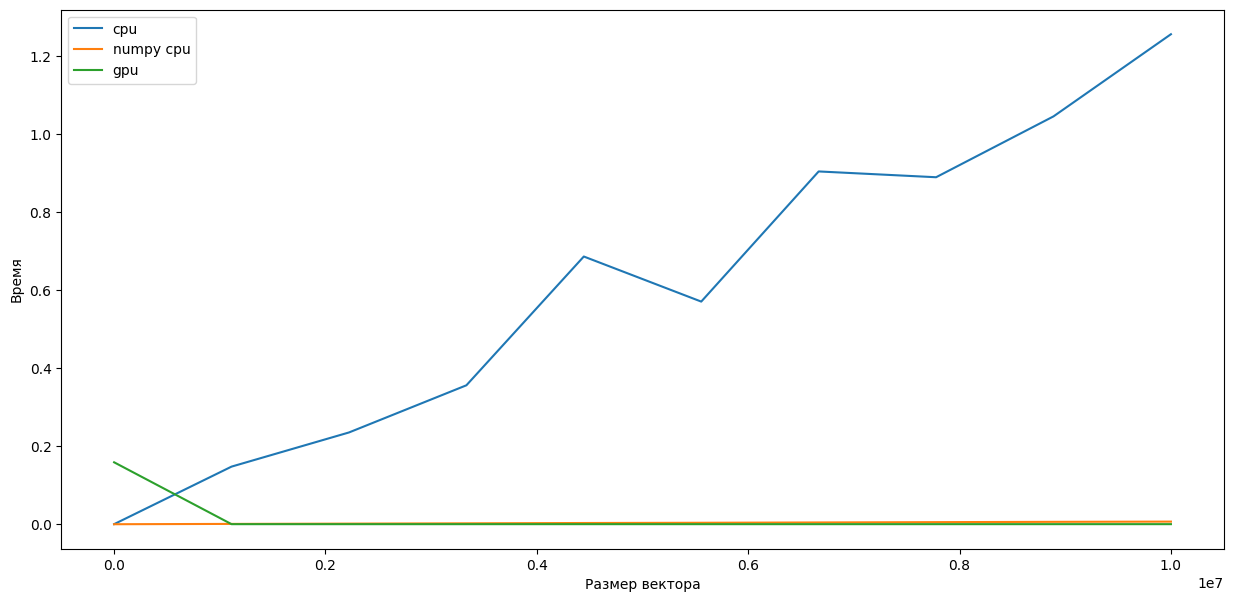

In [9]:
plt.figure(figsize=(15,7))
plt.plot(vector_size, cpu_times,label='cpu')
plt.plot(vector_size, numpy_cpu_times,label='numpy cpu')
plt.plot(vector_size, gpu_times, label='gpu')
plt.xlabel('Размер вектора')
plt.ylabel('Время')
plt.legend()
plt.savefig('cpu gpu numpy times.png',dpi=700)

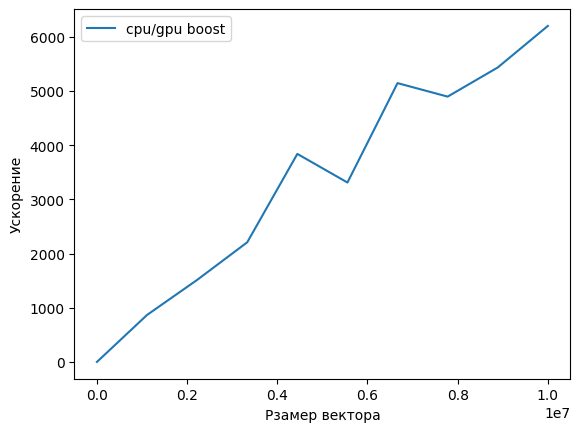

In [10]:
plt.plot(vector_size,cpu_times/gpu_times,label='cpu/gpu boost')
plt.xlabel('Рзамер вектора')
plt.ylabel('Ускорение')
plt.legend()
plt.savefig('cpu gpu boost.png',dpi=700)

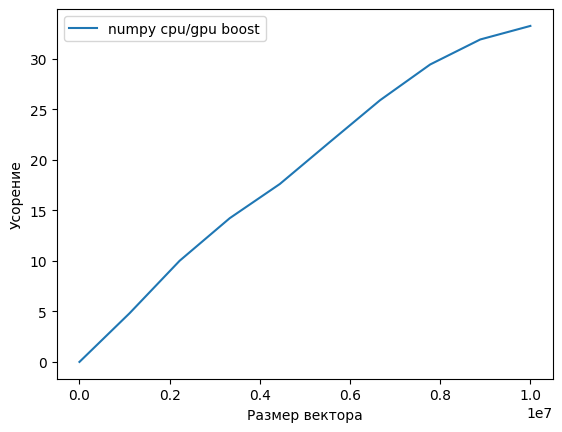

In [11]:
plt.plot(vector_size, numpy_cpu_times/gpu_times,label = 'numpy cpu/gpu boost')
plt.xlabel('Размер вектора')
plt.ylabel('Усорение')
plt.legend()
plt.savefig('numpy cpu gpu boost.png',dpi=700)